In [97]:
# abrir musicar e pré-processar melspectogram
import pandas as pd
import librosa as mimosa
import audioread
import os
import matplotlib as plt
import seaborn as sns
import numpy as np

musicGender = os.listdir("musics") # returns list
genderlabel = []
musicData = []

for gender in musicGender:
    genderMusics = os.listdir('./musics/{}'.format(gender))
    for music in genderMusics:
        genderlabel.append(gender)
        
        amplitude, sr = mimosa.load('./musics/{}'.format(gender)+'/{}'.format(music), offset=15, duration=15)

        melSpec = mimosa.feature.melspectrogram(y = amplitude, sr=sr, n_mels=128, fmax=8000)    
        melSpec_to_db = mimosa.power_to_db(melSpec, ref=np.max)
        resized_melSpec = np.resize(melSpec_to_db, (melSpec_to_db.shape[0], 1293))
        
        musicData.append(resized_melSpec)

mfcc_specData=np.stack(musicData)
musicData=np.array(musicData)
genderlabel=np.array(genderlabel)


In [98]:
# fazer encoding das categorias
import sklearn.preprocessing as preProSkL

labelEncoder = preProSkL.LabelEncoder()
labelEncoded = labelEncoder.fit(genderlabel)
labelEncodedTrans = labelEncoded.transform(genderlabel)
# inverse_transform to revert to normal

In [99]:
# normalizar dados por media
# não usado, mas pode ser comentado

# from sklearn.preprocessing import StandardScaler

# sc_X=StandardScaler()
# mfcc_specData = sc_X.fit_transform(mfcc_specData)

# mfcc_specData.head()


# mean = np.mean(musicData, axis=-1, keepdims=True)
# std = np.std(musicData, axis=-1, keepdims=True)


# Normalize the array by subtracting the mean and dividing by the standard deviation
# normalized_data = (musicData - mean) / std

# print(len(normalized_data))


In [100]:
# Normalização Min Max

indexMin=0
indexMax = 100

normalized_data = []
numCategories = int( len(labelEncodedTrans)/ 100)


for i in range(numCategories):

    max = mfcc_specData[indexMin:indexMax].max()
    min = mfcc_specData[indexMin:indexMax].min()

    h = 0
    for music in musicData[indexMin:indexMax]:

        xScaled = (music - min) / (max - min)
        normalized_data.append(xScaled)

    indexMin += 100
    indexMax += 100  

normalized_data=np.array(normalized_data)

print(len(normalized_data))


600


In [101]:
# # modelo usado, atravé da separação dos dados com k-folds

# from sklearn.model_selection import KFold
# from tensorflow import keras
# import matplotlib.pyplot as pyplot

# acc_per_fold = []
# loss_per_fold = []

# input_shape=(normalized_data.shape[1],normalized_data.shape[2],1)
# fold_no = 1

# kf = KFold(n_splits=3, random_state=42, shuffle=True)
# for train, test in kf.split(normalized_data):
#     model=keras.Sequential()

#     #1st layer
#     model.add(keras.layers.Conv2D(8,(3,3),activation="relu",input_shape=input_shape))
#     model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) 
#     model.add(keras.layers.BatchNormalization())

#     # #2nd layer
#     # model.add(keras.layers.Conv2D(8,(3,3),activation="relu"))
#     # model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) #pooling
#     # model.add(keras.layers.BatchNormalization())

#     # #3rd layer
#     # model.add(keras.layers.Conv2D(8,(1,1),activation="relu"))
#     # model.add(keras.layers.MaxPool2D((1,1),strides=(1,1),padding="same")) #pooling
#     # model.add(keras.layers.BatchNormalization())


#     #flatten the output
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(8,activation="relu"))
#     # model.add(keras.layers.Dropout(0.3))

#     #output layer
#     model.add(keras.layers.Dense(3,activation="softmax"))


#     optimizer=keras.optimizers.Adam(learning_rate=0.0001)
#     model.compile(optimizer=optimizer,
#         loss="sparse_categorical_crossentropy",
#         metrics=['accuracy'])
    
    
#     # Generate a print
#     print('------------------------------------------------------------------------')
#     print(f'Training for fold {fold_no} ...')
        
#     # normalized_data[train] = normalized_data[train].reshape((-1, normalized_data[train].shape[1], normalized_data[train].shape[2], 1))
#     history = model.fit(normalized_data[train],labelEncodedTrans[train],epochs=25, validation_data=(normalized_data[test], labelEncodedTrans[test]))

#     testError, testAccuracy = model.evaluate(normalized_data[test], labelEncodedTrans[test])
#     print("Accuracy on test set is:{}".format(testAccuracy))


#     print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {testError}; {model.metrics_names[1]} of {testAccuracy*100}%')
#     acc_per_fold.append(testAccuracy * 100)
#     loss_per_fold.append(testError)

#     # Increase fold number
#     fold_no = fold_no + 1

# # == Provide average scores ==
# print('------------------------------------------------------------------------')
# print('Score per fold')
# for i in range(0, len(acc_per_fold)):
#     print('------------------------------------------------------------------------')
#     print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
#     print('------------------------------------------------------------------------')
#     print('Average scores for all folds:')
#     print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
#     print(f'> Loss: {np.mean(loss_per_fold)}')
#     print('------------------------------------------------------------------------')
    

In [102]:
from tensorflow import keras

def theModel(filters, neurons, data):
    input_shape=(data.shape[1],data.shape[2],1)

    model=keras.Sequential()

    #input layer
    model.add(keras.layers.Conv2D(filters,(3,3),activation="relu",input_shape=input_shape))
    model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) 
    model.add(keras.layers.BatchNormalization())


    #flatten the output
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(filters,activation="relu"))
    # model.add(keras.layers.Dropout(0.3))

    #output layer
    model.add(keras.layers.Dense(neurons,activation="softmax"))


    optimizer=keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy'])
    
    return model



In [103]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as pyplot

def trainTestModel(splitNumb, filters, data, labels):
    acc_per_fold = []
    loss_per_fold = []

    fold_no = 1


    kf = KFold(n_splits=splitNumb, random_state=42, shuffle=True)
    for train, test in kf.split(data):
        
        print("index:{}".format(splitNumb))
        print("filter:{}".format(filters))

        cnnModel = theModel(filters, splitNumb, data)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
            
        history = cnnModel.fit(data[train],labels[train],epochs=25, validation_data=(data[test], labels[test]))

        testError, testAccuracy = cnnModel.evaluate(data[test], labels[test])
        print("Accuracy on test set is:{}".format(testAccuracy))

        print(f'Score for fold {fold_no}: {cnnModel.metrics_names[0]} of {testError}; {cnnModel.metrics_names[1]} of {testAccuracy*100}%')
        acc_per_fold.append(testAccuracy * 100)
        loss_per_fold.append(testError)

        fold_no = fold_no + 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
        print('------------------------------------------------------------------------')
        print('Average scores for all folds:')
        print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
        print(f'> Loss: {np.mean(loss_per_fold)}')
        print('------------------------------------------------------------------------')

    return np.mean(acc_per_fold)

In [104]:
import math

index = 1
filters = 5
mappingAccuracy = []


for x in range(numCategories):
    if index != 1:
        for filter in range(filters):
            filter += 4
            dataInterval =  normalized_data[0:100 * index]
            labels = labelEncodedTrans[0:100 * index]
            accuracy  = trainTestModel(index, filter, dataInterval, labels)
          
            mappingAccuracy.append({'acc': math.ceil(accuracy), 'numMusicas': index, 'filtrosCNN': filter})
        
    index = index + 1


index:2
filter:4
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
4/4 [==============================] - 3s 367ms/step - loss: 0.8490 - accuracy: 0.5000 - val_loss: 0.6971 - val_accuracy: 0.4900
Epoch 2/25
4/4 [==============================] - 1s 310ms/step - loss: 0.5972 - accuracy: 0.6700 - val_loss: 0.8053 - val_accuracy: 0.4900
Epoch 3/25
4/4 [==============================] - 1s 322ms/step - loss: 0.5501 - accuracy: 0.6800 - val_loss: 0.8841 - val_accuracy: 0.4900
Epoch 4/25
4/4 [==============================] - 1s 319ms/step - loss: 0.5178 - accuracy: 0.6800 - val_loss: 0.8520 - val_accuracy: 0.4900
Epoch 5/25
4/4 [==============================] - 1s 343ms/step - loss: 0.4857 - accuracy: 0.8400 - val_loss: 0.8284 - val_accuracy: 0.4900
Epoch 6/25
4/4 [==============================] - 1s 333ms/step - loss: 0.4792 - accuracy: 0.7000 - val_loss: 0.7889 - val_accuracy: 0.4900
Epoch 7/25
4/4 [==============================

In [107]:

# Criar um DataFrame a partir da lista de dicionários
df = pd.DataFrame(mappingAccuracy)

# Encontrar o elemento com valor máximo de cada categoria
elementos_maximos = df.groupby('numMusicas').apply(lambda x: x.loc[x['acc'].idxmax()]).reset_index(drop=True)

# Imprimir os elementos com valor máximo de cada categoria
for _, elemento in elementos_maximos.iterrows():
    print(elemento.to_dict())

{'acc': 72, 'numMusicas': 2, 'filtrosCNN': 8}
{'acc': 80, 'numMusicas': 3, 'filtrosCNN': 6}
{'acc': 71, 'numMusicas': 4, 'filtrosCNN': 8}


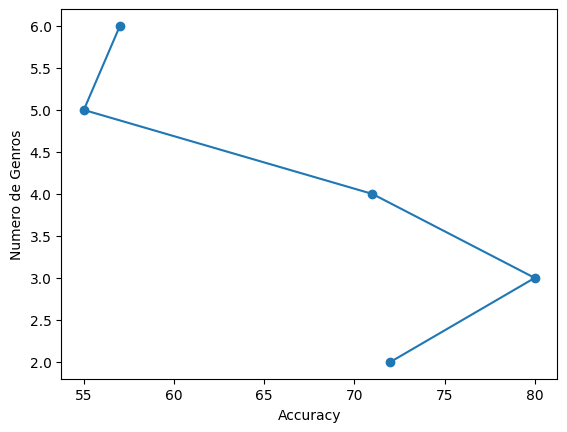

In [133]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(elementos_maximos['acc'],elementos_maximos['numMusicas'], 'o-')
ax1.set_ylabel('Numero de Genros')
ax1.set_xlabel('Accuracy')

plt.show()


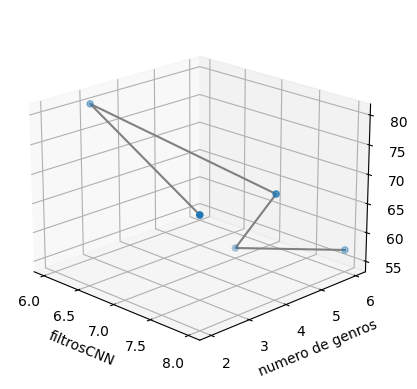

In [134]:
fig = plt.figure()
ax = plt.axes(projection='3d')

zline = elementos_maximos['acc']
xline = elementos_maximos['filtrosCNN']
yline = elementos_maximos['numMusicas']
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata =  elementos_maximos['acc']
xdata = elementos_maximos['filtrosCNN']
ydata =  elementos_maximos['numMusicas']
ax.set_ylabel('numero de genros')
ax.set_xlabel('filtrosCNN')
ax.set_zlabel('Accuracy')
ax.scatter3D(xdata, ydata, zdata)


ax.view_init(elev=20., azim=-45, roll=0)

In [ ]:
# separação antiga dos dados de treino e teste

# import sklearn.model_selection as modelSelec

# X_train, X_test, y_train, y_test = modelSelec.train_test_split(normalized_data, labelEncodedTrans, test_size=0.25, random_state=42)

# # X_train, X_test, y_val, y_val = modelSelec.train_test_split(mfcc_specData, labelEncodedTrans, test_size=0.5, random_state=42)
# X_test,X_validation,y_test,y_validation=modelSelec.train_test_split(X_test,y_test,test_size=0.2, random_state=42)


In [ ]:
# # criados dos plots/imagens através dos dados normalizados 

# import matplotlib.pyplot as pyplot

# musicCounter = 0

# path = './musicsPlts'
# if not os.path.exists(path):
#     os.mkdir(path)

# for gender in musicGender:
#     genderPath = '{}'.format(path) + '/{}'.format(gender)
#     if not os.path.exists(genderPath):
#         os.mkdir(genderPath)

# for index in range(len(normalized_data)):
#     fig, ax = pyplot.subplots()
#     img = mimosa.display.specshow(normalized_data[index], x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
#     fig.colorbar(img, ax=ax, format='%+2.0f dB')

#     ax.set(title='Mel-frequency spectrogram')

#     if index % 100 == 0:
#         musicCounter = 0
    
#     pyplot.savefig('{}'.format(path) + '/{}'.format(genderlabel[index]) + '/{}'.format(musicCounter) + '.png')

#     musicCounter +=1




In [ ]:
# # formato dos dados para modelo antigo

# print(X_train.shape)
# input_shape=(X_train.shape[1],X_train.shape[2],1)
# print(X_train.shape)
# print(input_shape)


In [ ]:
# # modelo antigo testado com variantes

# from tensorflow import keras

# model=keras.Sequential()
# #1st layer
# model.add(keras.layers.Conv2D(24,(3,3),activation="relu",input_shape=input_shape))
# model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) 
# model.add(keras.layers.BatchNormalization())

# #2nd layer
# model.add(keras.layers.Conv2D(24,(3,3),activation="relu"))
# model.add(keras.layers.MaxPool2D((3,3),strides=(2,2),padding="same")) #pooling
# model.add(keras.layers.BatchNormalization())

# #3rd layer
# model.add(keras.layers.Conv2D(24,(2,2),activation="relu"))
# model.add(keras.layers.MaxPool2D((2,2),strides=(2,2),padding="same")) #pooling
# model.add(keras.layers.BatchNormalization())


# #flatten the output
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(20,activation="relu"))
# model.add(keras.layers.Dropout(0.2))

# #output layer
# model.add(keras.layers.Dense(10,activation="softmax"))

# optimizer=keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=optimizer,
#     loss="sparse_categorical_crossentropy",
#     metrics=['accuracy'])


In [ ]:
# #  treino do modelo antigo 

# X_train = X_train.reshape((-1, X_train.shape[1], X_train.shape[2], 1))
# print(X_train.shape[0])
# # history = model.fit(X_train,y_train,epochs=35, validation_data=(X_validation, y_validation))
# history = model.fit(X_train,y_train,epochs=35, validation_data=(X_test, y_test))

In [ ]:
# # validação do modelo antigo

# import matplotlib.pyplot as pyplot

# print(history.history)

# testError, testAccuracy = model.evaluate(X_test, y_test)
# print("Accuracy on test set is:{}".format(testAccuracy))

# pyplot.plot(history.history['accuracy'], label='train_accuracy')
# pyplot.plot(history.history['val_accuracy'], label = 'val_accuracy')
# pyplot.xlabel('Epoch')
# pyplot.ylabel('Accuracy')
# pyplot.ylim([0.1, 1.1])
# pyplot.legend(loc='lower right')